In [1]:
%load_ext autoreload
%autoreload 2

# Experimental demonstration of memory-enhanced quantum communication

This notebook follows work published in [This paper](https://arxiv.org/abs/1909.01323) (PDF in current folder). 

### Just enough quantum key distribution (if you need it)

The paper shows a method to improve quantum key distribution using a quantum memory and optical qubits. So we begin with a minimal introduction/reminder on quantum key distributions. The distribution protocol shown below is called BB84 and  uses optical qubits encoded on the polarization state of photons, but there are many other methods. 

The goal of the game is to exchange a _classical_ encryption key between Alice and Bob, but they want to use a _quantum_ channel to ensure their key was not compromised by the evil Eve. To do this, they agree on two possible orthogonal basis in which they may encode qubits: X (45/135 degree polarization) or + (0/90 degree polarization). Alice randomizes a string of classical bits and polarization orientations and sends them to Bob. Bob chooses an orientation for his polarizer at random and measures the qubit. Alice and Bob then have a chat over an insecure line and Bob tells Alice what polarizer orientations he used for each measurement. For each of Bob's attempts, Alice replies "correct" or "incorrect". The measurements Bob performed with correct orientations resulted in the same bits as those transmitted by Alice and can now constitue an encription key. This is called _sifting_ because you throw away some of the bits (where the polarizer orientation did not match). There are more details on the protocol but they aren't important for us right now.

<center><img src="figure_0.png"/></center>



## The SiV setup


The system under consideration is a Si-V (silicon-vacancy center) in a diamon photonic cavity that is coupled to an optical fiber. This system is used to demonstrate an enhancement in the rate of quantum key distribution (QKD) which uses the SiV as a quantum memory. The memory enables surpassing the theoretical limit of the QKD rate limit in a lossy channel. 


<center><img src="figure_1.png"/></center>


The spin state of the  SiV (up or down) can be controlled using microwave pulses applied by the gold element surrounding the SiV. 

The SiV is embedded in a photonic crystal waveguide which increases the coupling between the incoming photons and the SiV. Cooperativity of this cavity is measured to be  $C=105\pm 11$.

To detect the SiV state, the reflection of a photon from the cavity is measured. If the spin state is $\uparrow$, there is reflection and if it is $\downarrow$, there is none (very little). 

### The photonic qubit

The qubit is encoded on relative phase and timing of a pair of optical pulses, separated by $\delta t = 142 ns$. The pulses are called "early" or "late" photons (though they are weak coherent pulses). 

### Entangling a photonic qubit with a spin 

A photon is refelected from the cavity if and only if the spin state is $\uparrow$. As is shown on the diagram below, the spin is prepared in the $|\leftarrow \rangle= |\uparrow\rangle+ |\downarrow\rangle$ by a $\pi/2$ (MW) pulse and a (MW) $\pi$ pulse is inserted between each pair of photonic pulses. The reflected state can then not have the $|e\uparrow\rangle$ or $| l\downarrow \rangle$ components.

However, as the pulses travel from the cavity and to the pair of single photon detectors, they are passed thorugh a Time-Delay Interferometer (TDI). The interferometer allows photons to go though either a long path or a short path, whose path difference exactly compensates for the $\delta t$ time difference between the pulses. This erases the time-bin information (early or late) and leves the system in an entangled state $|\pm\rangle \propto |e\rangle \pm |l\rangle$ 


### The memory enhanced QKD protocol

We now finally reach the suggested protocol. Unlike the BB84 case, Alice and Bob each take turns sending qubits to Charlie who's in the middle between them. Charlie holds the memory device (spin) and is able to measure it. 

In the image below a set of pulses is shown (red) and for different relative phases (in blue) between each pair (controlled by a optical phase shifter) the qubit state is specified below the image.


<center><img src="figure_qubits.png"/></center>

The Z basis in the photonic perspective is whether the photon is in the early or late time bin. The X Basis is the early+late or early-late state. The image below shows a arrival time histogram on one of the single photon detectors (+1). So the +x state would be measured by any click on the +1 detector at time 0 (relative the photon pair timing) and the -x state would be detected by the same pulse on the -1 detector. 

<center><img src="figure_2.png"/></center>


# Experimental sequence: spin qubit spectroscopy

2021-04-05 14:36:09,243 - qm - INFO - Performing health check
2021-04-05 14:36:18,066 - qm - INFO - Health check passed
2021-04-05 14:36:18,363 - qm - WARNING - streaming adc data without adc_trace flag might cause performance issues
2021-04-05 14:36:18,379 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-05 14:36:18,422 - qm - INFO - Flags: 
2021-04-05 14:36:18,423 - qm - INFO - Simulating Qua program


<ipython-input-4-88000bd7a235>:42: QMDeprecationWarning: _TimeTagging.raw is deprecated since 0.8: use time_tagging.analog instead
  measure('readout', 'readout1', 'adc', time_tagging.raw(result1, meas_len, targetLen=resultLen1))
<ipython-input-4-88000bd7a235>:43: QMDeprecationWarning: _TimeTagging.raw is deprecated since 0.8: use time_tagging.analog instead
  measure('readout', 'readout2', None, time_tagging.raw(result2, meas_len, targetLen=resultLen2))


Text(0, 0.5, 'counting')

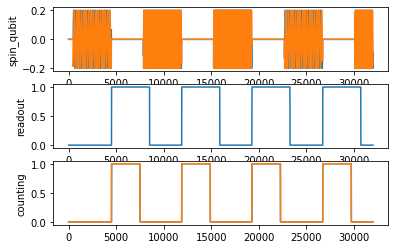

In [4]:
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.qua import *
from qm import SimulationConfig
from Configuration import config

import matplotlib.pyplot as plt

#############
# Time trace:
#############

meas_len = 1e3
rep_num = 1e7
Qmm = QuantumMachinesManager()
Qmm.close_all_quantum_machines()
qm = Qmm.open_qm(config)
with program() as spin_qubit_spec:

    ##############################
    # Declare real-time variables:
    ##############################

    n = declare(int)
    f = declare(int)
    result1 = declare(int, size=int(meas_len/500))
    resultLen1 = declare(int)
    result2 = declare(int, size=int(meas_len/500))
    resultLen2 = declare(int)
    counts = declare(int)


    ###############
    # The sequence:
    ###############

    with for_(n, 0, n < rep_num, n + 1):
        with for_(f, 4e6, f<14e6, f+4e6):
            update_frequency('spin_qubit', f)
            play('saturation', 'spin_qubit', duration=1000)
            align('spin_qubit', 'readout', 'readout1', 'readout2')
            play('on', 'readout', duration=1000)
            measure('readout', 'readout1', 'adc', time_tagging.raw(result1, meas_len, targetLen=resultLen1))
            measure('readout', 'readout2', None, time_tagging.raw(result2, meas_len, targetLen=resultLen2))
            assign(counts, resultLen1+resultLen2)

        save(counts, 'counts')


        # with for_(n, 0, n < resultLen1, n + 1):
        #     save(result1[n], "res1")
        # with for_(p, 0, p < resultLen2, p + 1):
        #     save(result2[p], "res2")


job = qm.simulate(spin_qubit_spec, SimulationConfig(8000))
# job.get_simulated_samples().con1.plot()

sim = job.get_simulated_samples()
pulses = job.simulated_analog_waveforms()
dig_pulses = job.simulated_digital_waveforms()


plt.figure(1)
ax1 = plt.subplot(311)
plt.plot(sim.con1.analog['1'])
plt.plot(sim.con1.analog['2'])
plt.ylabel('spin_qubit')

plt.subplot(312)
plt.plot(sim.con1.digital['1'])
plt.ylabel('readout')

plt.subplot(313)
plt.plot(sim.con1.digital['7'])
plt.plot(sim.con1.digital['8'])
plt.ylabel('counting')


# Experimental sequence: Spin-photon entanglement

2021-04-05 22:53:16,641 - qm - INFO - Performing health check
2021-04-05 22:53:16,654 - qm - INFO - Health check passed
2021-04-05 22:53:16,859 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-05 22:53:16,884 - qm - INFO - Flags: 
2021-04-05 22:53:16,886 - qm - INFO - Simulating Qua program


C:\Users\gal\Google Drive\qua-libs\examples\Workshops\CQE\8.memory-enhanced-quantum-comms\qua_macros.py:21: QMDeprecationWarning: _TimeTagging.raw is deprecated since 0.8: use time_tagging.analog instead
  measure('readout', 'readout1', None, time_tagging.raw(result1, meas_len, targetLen=resultLen1))
C:\Users\gal\Google Drive\qua-libs\examples\Workshops\CQE\8.memory-enhanced-quantum-comms\qua_macros.py:22: QMDeprecationWarning: _TimeTagging.raw is deprecated since 0.8: use time_tagging.analog instead
  measure('readout', 'readout2', None, time_tagging.raw(result2, meas_len, targetLen=resultLen2))
<ipython-input-5-db79774f2076>:61: QMDeprecationWarning: _TimeTagging.raw is deprecated since 0.8: use time_tagging.analog instead
  measure('readout', 'readout1', None, time_tagging.raw(result1, meas_len, targetLen=resultLen1))
<ipython-input-5-db79774f2076>:62: QMDeprecationWarning: _TimeTagging.raw is deprecated since 0.8: use time_tagging.analog instead
  measure('readout', 'readout2', Non

Text(0, 0.5, 'counting')

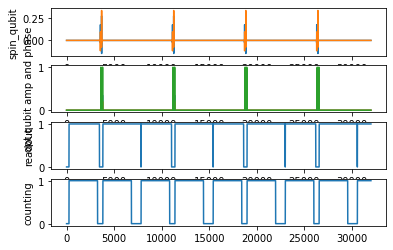

In [5]:
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.qua import *
from qm import SimulationConfig
from Configuration import config

import matplotlib.pyplot as plt


#############
# Time trace:
#############
from qua_macros import reset_spin

meas_len = 1e3
rep_num = 1e7
threshold = 7
Qmm = QuantumMachinesManager()
Qmm.close_all_quantum_machines()
qm = Qmm.open_qm(config)
with program() as spin_qubit_spec:

    ##############################
    # Declare real-time variables:
    ##############################

    n = declare(int)
    k = declare(int)
    se = declare(bool)

    result1 = declare(int, size=int(meas_len / 500))
    resultLen1 = declare(int)
    result2 = declare(int, size=int(meas_len / 500))
    resultLen2 = declare(int)

    ###############
    # The sequence:
    ###############
    with for_(n, 0, n < rep_num, n + 1):

        reset_spin(threshold)

        # sequence:
        play('pi2', 'spin_qubit')
        align('spin_qubit', 'opt_qubit_amp')

        play('photon', 'opt_qubit_amp')
        wait(32, 'opt_qubit_amp')
        align('opt_qubit_amp', 'opt_qubit_phase')
        play('phase_shift', 'opt_qubit_phase')
        play('photon', 'opt_qubit_amp')

        wait(18, 'spin_qubit')
        play('pi', 'spin_qubit')
        # align('spin_qubit', 'opt_qubit_amp', 'opt_qubit_phase')



        # Readout:
        align('opt_qubit_amp', 'opt_qubit_phase', 'readout', 'readout1', 'readout2')
        play('on', 'readout', duration=1000)
        measure('readout', 'readout1', None, time_tagging.raw(result1, meas_len, targetLen=resultLen1))
        measure('readout', 'readout2', None, time_tagging.raw(result2, meas_len, targetLen=resultLen2))
        # measure_spin('z', threshold, se)

        # save
        i = declare(int)
        j = declare(int)
        with for_(i, 0, i < resultLen1, i + 1):
            save(result1[i], 'time_tags_plus')
        with for_(j, 0, j < resultLen2, j + 1):
            save(result2[j], 'time_tags_plus')

job = qm.simulate(spin_qubit_spec, SimulationConfig(8000))
# job.get_simulated_samples().con1.plot()

sim = job.get_simulated_samples()
pulses = job.simulated_analog_waveforms()
dig_pulses = job.simulated_digital_waveforms()


plt.figure(1)
ax1 = plt.subplot(411)
plt.plot(sim.con1.analog['1'])
plt.plot(sim.con1.analog['2'])
plt.ylabel('spin_qubit')

plt.subplot(412)
plt.plot(sim.con1.analog['3'])
plt.plot(sim.con1.analog['4'])
plt.plot(sim.con1.digital['3'])
plt.ylabel('opt qubit amp and phase')

plt.subplot(413)
plt.plot(sim.con1.digital['1'])
plt.ylabel('readout')

plt.subplot(414)
plt.plot(sim.con1.digital['7'])
# plt.plot(sim.con1.digital['8'])
plt.ylabel('counting')

